In [94]:
import deluca
import jax
import control as ct
import numpy as np
from scipy.signal import cont2discrete
from scipy.signal import square
import jax.numpy as jnp
from deluca.agents._gpc import GPC
from deluca.agents._lqr import LQR
from tqdm import tqdm

In [95]:
def double_integrator_dt(m=1,b=0.5,k=5,dt=0.1): 
    A = np.array([[0, 1], [-k/m, -b/m]])
    B = np.array([[0], [1/m]])
    n_states = A.shape[0]
    C, D= np.eye(1,n_states), 0
    sys = cont2discrete((A,B,C,D), dt, method='zoh', alpha=None)
    A,B = sys[0], sys[1]
    return A,B,dt

In [96]:
A, B, dt = double_integrator_dt()
A_true, B_true, _ = double_integrator_dt(m=1.2, b=0.6, k=6)
Q, R = 500*jnp.eye(2), jnp.eye(1)

# initialize classes
agpc = GPC(
    A=A,
    B=B,
    Q = Q,
    R = R,
    H=80,
    HH=79,
    lr_scale=0.00005,
    decay= True,
    )
alqr = LQR(A,B,Q,R)

# initialize states
x0 = jnp.array([[0],[0]])
agpc.state = x0
x_gpc = x0
x_lqr = x0

In [97]:
def quad_loss(x: jnp.ndarray, u: jnp.ndarray):
    return (x.T @ Q @ x) + u.T @ R @u

In [98]:
T = 200

# intialize arrays of zeros
uv_gpc, xv_gpc, wv_gpc, gv_gpc =  np.zeros((1,T)), np.zeros((2,T)), np.zeros((2,T)), np.zeros((1,T))
cv_gpc = np.zeros((1,T))
cv_lqr = np.zeros((1,T))
uv_lqr, xv_lqr = np.zeros((1,T)), np.zeros((2,T))
uv2_gpc = np.zeros((1,T))

tv = np.arange(0,T)*dt
w2 = 100*dt*square(tv*0.3,duty=0.5) + 1

for i in tqdm(range(T)):
#for i in range(T):

    # Compute disturbance 
    w = jnp.array([[0.],[w2[i]]])
    #w = jnp.array([[0.],[10.]])
    
    xv_gpc[:,i] = agpc.state.reshape((2,)) # put states into array
    xv_lqr[:,i] = x_lqr.reshape((2,)) # put the current state into a vector of all states
    
    # get control actions
    u_gpc, u2_gpc = agpc.get_action(agpc.state) # compute control action for GPC
    u_lqr = alqr(x_lqr) # compute the control action for the next iteration
    
    # compute cost
    c_gpc = quad_loss(x_gpc,u_gpc) # compute cost for GPC
    c_lqr = quad_loss(x_lqr,u_lqr) # compute cost for LQR
    
    # add noise and get next state
    x_gpc = A @ agpc.state + B @ u_gpc + w
    #w = (A_true @ agpc.state + B_true @ u_gpc) - (A @ agpc.state + B @ u_gpc) 
    agpc.update(x_gpc,u_gpc)
    
    #x_lqr = A_true @ x_lqr + B_true @ u_lqr # get the next state
    x_lqr = A @ x_lqr + B @ u_lqr + w
    
    # get policy loss
    g_gpc = agpc.policy_loss(agpc.M,agpc.noise_history)
    
    # put scalars into vectors
    uv_gpc[:,i], wv_gpc[:,i], gv_gpc[:,i] = u_gpc.reshape((1,)), w.reshape((2,)), g_gpc.reshape((1,))
    uv2_gpc[:,i] = u2_gpc.reshape((1,))
    cv_lqr[:,i] = c_lqr.reshape((1,))
    cv_gpc[:,i] = c_gpc.reshape((1,))
    uv_lqr[:,i] = u_lqr.reshape((1,)) 
    

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:07<00:00, 25.99it/s]


In [99]:
s_gpc, r_gpc = np.matmul(B, uv_gpc), np.matmul(A, xv_gpc)
s1_gpc, s2_gpc = s_gpc[0,:] + xv_gpc[0,:],  s_gpc[1,:] + xv_gpc[1,:]
r1_gpc, r2_gpc = r_gpc[0,:], r_gpc[1,:]

s_lqr, r_lqr = np.matmul(B, uv_lqr), np.matmul(A, xv_lqr)
s1_lqr, s2_lqr = s_lqr[0,:] + xv_lqr[0,:],  s_lqr[1,:] + xv_lqr[1,:]
r1_lqr, r2_lqr = r_lqr[0,:], r_lqr[1,:]

In [100]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'],rcParams['font.serif'],rcParams['text.usetex'] = 'serif', ['Computer Modern Roman'], True
rcParams['font.size'], rcParams['axes.labelsize'],rcParams['axes.titlesize'] = 16, 16, 18
rcParams['xtick.labelsize'], rcParams['ytick.labelsize'] = 14, 14

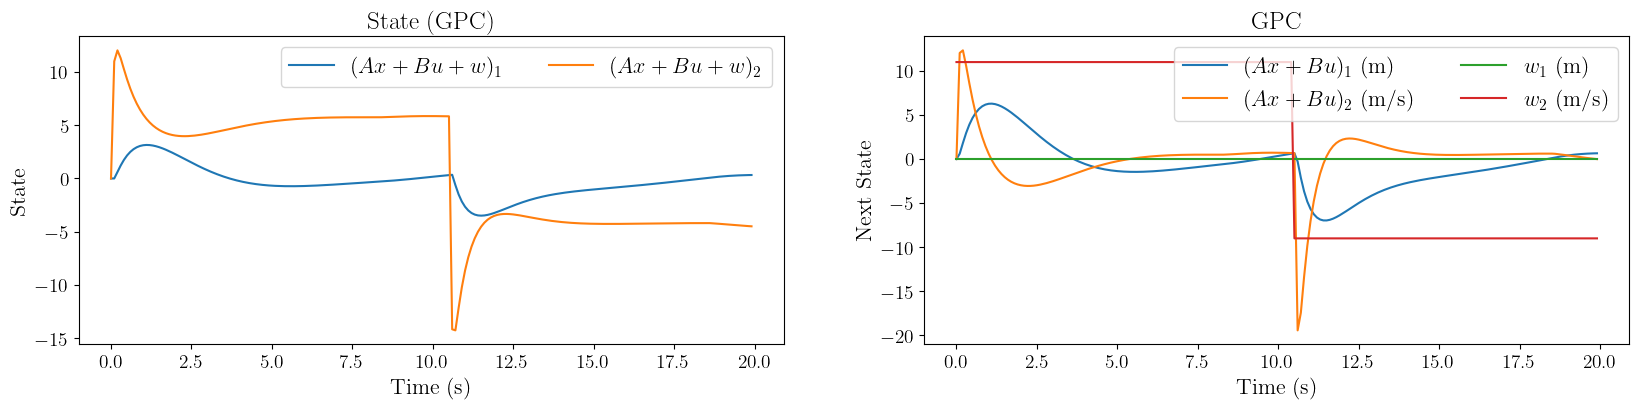

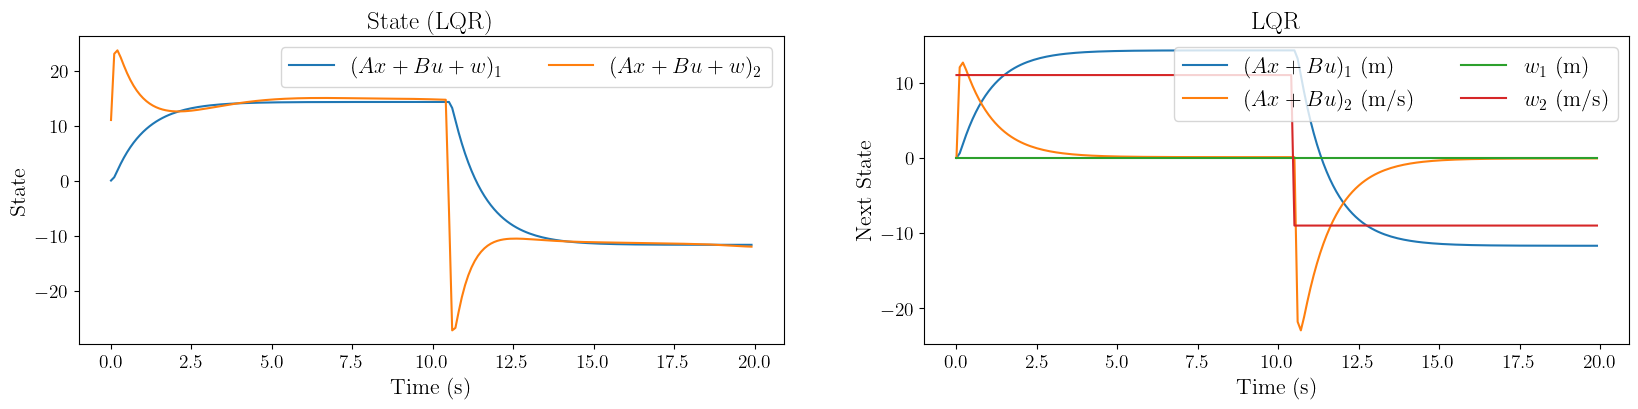

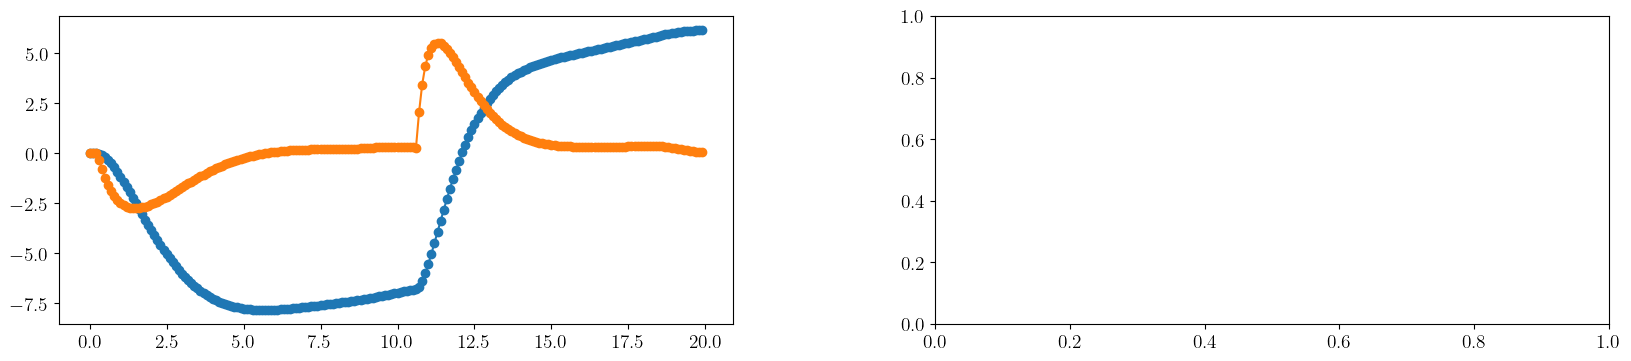

In [101]:
fig1, ax1 = plt.subplots(1, 2, figsize=(20, 4)) # Create a figure and axis for GPC
ax1[0].plot(tv,xv_gpc[0,:],label="$(Ax+Bu+w)_1$")
ax1[0].plot(tv,xv_gpc[1,:],label="$(Ax+Bu+w)_2$")
ax1[0].set_title("State (GPC)")
ax1[0].set_xlabel("Time (s)")
ax1[0].set_ylabel("State")
ax1[0].legend(loc="upper right", ncol=2)

# Show that input exactly cancels out disturbances
ax1[1].plot(tv, s1_gpc+r1_gpc, label="$(Ax + Bu)_1$ (m)")
ax1[1].plot(tv, s2_gpc+r2_gpc, label="$(Ax+Bu)_2$ (m/s)")
ax1[1].plot(tv,wv_gpc[0,:], label="$w_1$ (m)")
ax1[1].plot(tv,wv_gpc[1,:], label="$w_2$ (m/s)")

ax1[1].set_xlabel("Time (s)")
ax1[1].legend(loc='upper right',ncol=2)
ax1[1].set_ylabel("Next State")
ax1[1].set_title("GPC")

fig2, ax2 = plt.subplots(1,2,figsize=(20,4))
ax2[0].plot(tv,s1_lqr+r1_lqr+wv_gpc[0,:],label="$(Ax+Bu+w)_1$")
ax2[0].plot(tv,s2_lqr+r2_gpc+wv_gpc[1,:],label="$(Ax+Bu+w)_2$")
ax2[0].set_title("State (LQR)")

ax2[0].set_xlabel("Time (s)")
ax2[0].set_ylabel("State")
ax2[0].legend(loc="upper right", ncol=2)

ax2[1].plot(tv, s1_lqr+r1_lqr, label="$(Ax + Bu)_1$ (m)")
ax2[1].plot(tv, s2_lqr+r2_lqr, label="$(Ax+Bu)_2$ (m/s)")
ax2[1].plot(tv,wv_gpc[0,:], label="$w_1$ (m)")
ax2[1].plot(tv,wv_gpc[1,:], label="$w_2$ (m/s)")

ax2[1].set_xlabel("Time (s)")
ax2[1].legend(loc='upper right',ncol=2)
ax2[1].set_ylabel("Next State")
ax2[1].set_title("LQR")

fig4, ax4 = plt.subplots(1,2,figsize=(20,4))
ax4[0].plot(tv,xv_gpc[0,:] - xv_lqr[0,:],label="$(Ax+Bu+w)_1$",marker='o')
ax4[0].plot(tv,xv_gpc[1,:] - xv_lqr[1,:],label="$(Ax+Bu+w)_2$",marker='o')

# ax2[0].set_ylim(bottom=-1,top=3)
# ax2[1].set_ylim(bottom=-1,top=3)
# ax1[0].set_ylim(bottom=-1,top=3)
# ax1[1].set_ylim(bottom=-1,top=3)

# Show the plot
plt.subplots_adjust(wspace=0.3, hspace=0.7)
plt.show()

In [102]:
#(s1_lqr+r1_lqr+wv_gpc[0,:] - (s1_gpc+r1_gpc+wv_gpc[0,:]))
#xv_gpc - xv_lqr

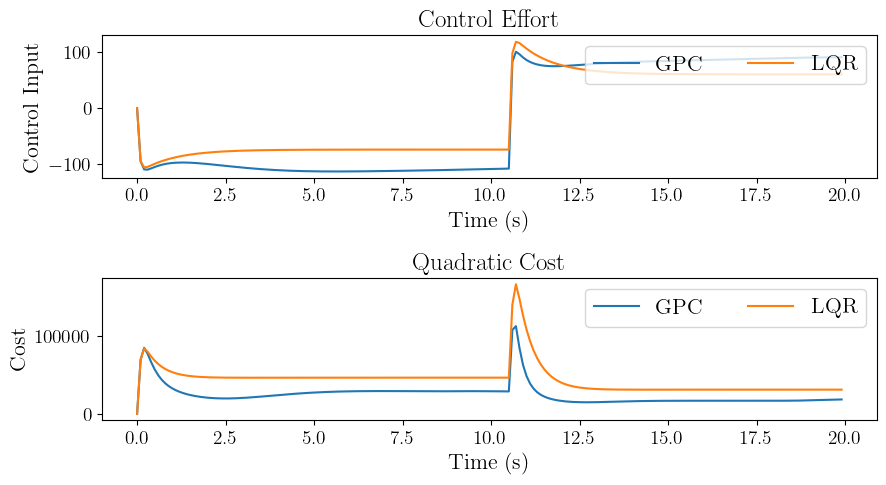

In [103]:
# plot control effort
fig3, ax3 = plt.subplots(2, 1, figsize=(10, 5)) # Create a figure and axis for GPC
ax3[0].plot(tv, uv_gpc.reshape((T,)), label="GPC")
ax3[0].plot(tv, uv_lqr.reshape((T,)), label="LQR")
#ax3[0].plot(tv, uv2_gpc.reshape((T,)),label="$u_2$") # due to disturbance rejection
#ax3[0].plot(tv,(uv_gpc - uv_lqr).reshape((T,)))
ax3[0].set_xlabel("Time (s)")
ax3[0].set_title("Control Effort")
ax3[0].set_ylabel("Control Input")
ax3[0].legend(loc="upper right",ncol=2)

cv_gpc = cv_gpc.reshape((T,))
cv_lqr = cv_lqr.reshape((T,))
regret = np.cumsum(cv_gpc - cv_lqr)
gv_gpc = gv_gpc.reshape((T,))

ax3[1].plot(tv,cv_gpc,label="GPC")
ax3[1].plot(tv,cv_lqr,label="LQR")
ax3[1].legend(ncol=2,loc='upper right')
ax3[1].set_xlabel("Time (s)")
ax3[1].set_title("Quadratic Cost")
ax3[1].set_ylabel("Cost")

#ax3[2].plot(tv,regret)
plt.subplots_adjust(wspace=0.3, hspace=0.7)
plt.show()